# Milestone Project 1 - Classification

In this project we will be working on a classification model to predict heart disease development

## Problem Definition

Given a number of clinical parameters for a patient, can we predict wether or not they have heart disease?

## Data

We will be using the UCI Heart Disease Dataset

## Evaluation

We're aiming at a 95% accuracy score during the proof of concept so we can move forward

## Data Dictionary

This is our data dictionary with definitions for each column

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
   * 0: Typical angina: chest pain related decrease blood supply to the heart
   * 1: Atypical angina: chest pain not related to heart
   * 2: Non-anginal pain: typically esophageal spasms (non heart related)
   * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
   * serum = LDL + HDL + .2 * triglycerides
   * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
   * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
   * 0: Nothing to note
   * 1: ST-T Wave abnormality
      * can range from mild symptoms to severe problems
      * signals non-normal heart beat
   * 2: Possible or definite left ventricular hypertrophy
      * Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise 
11. unhealthy heart will stress more
12. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
13. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
14. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [28]:
# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import *

# Pipeline Tools
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv("resources/heart-disease.csv")
data.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
236,58,1,0,125,300,0,0,171,0,0.0,2,2,3,0
154,39,0,2,138,220,0,1,152,0,0.0,1,0,2,1
216,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
227,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0
237,60,1,0,140,293,0,0,170,0,1.2,1,2,3,0


## EDA - Exploratory Data Analysis

The goal of EDA is to familiarize ourselves with the data and learn the ins-and-outs of our dataset

In [3]:
# Using data.info() to get a broad view of columns and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
# Missing values?
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
# Numerical stats
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
# Will split the data set by target so it's easy to plot it
healthy = data[data["target"] == 0]
disease = data[data["target"] == 1]

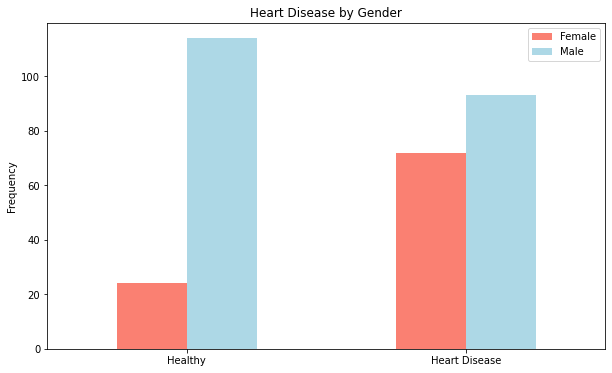

In [7]:
# Lets compare how some columns compare with target and plot it as a bar graph
pd.crosstab(data.target, data.sex).plot(kind='bar', 
                                        figsize=(10,6),
                                        color=['salmon', 'lightblue'])
plt.title("Heart Disease by Gender")
plt.xlabel(None)
plt.ylabel("Frequency")
plt.xticks([0,1], ["Healthy", "Heart Disease"], rotation=0)
plt.legend(["Female", "Male"]);

It may look like women are more prone to heart disease, but that may also be a bias on our data idealy we would consult with the experts to see if our EDA observations make sense

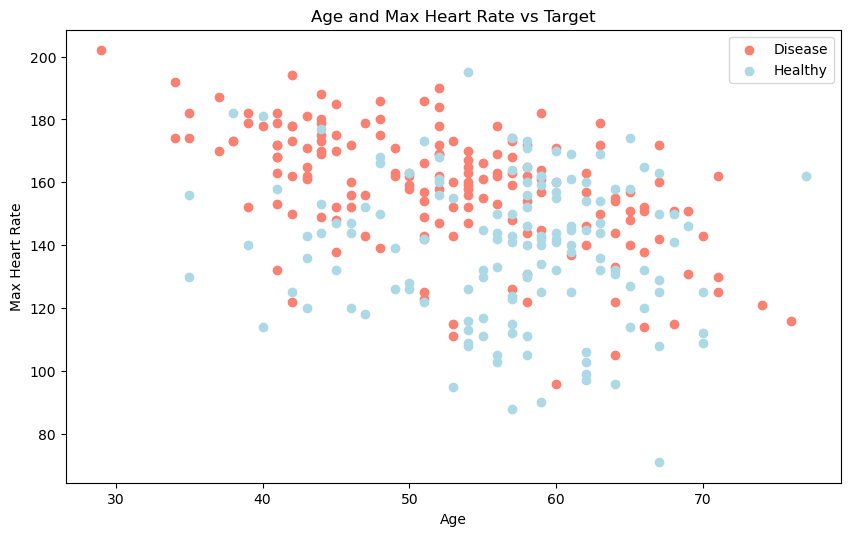

In [8]:
# Age and Max Heart Rate vs Disease
fig, ax = plt.subplots(figsize=(10,6), dpi=100)

ax.scatter(disease['age'], disease['thalach'], color = 'salmon')
ax.scatter(healthy['age'], healthy['thalach'], color = 'lightblue')

ax.legend(["Disease", "Healthy"])

ax.set(title ="Age and Max Heart Rate vs Target",
       xlabel="Age",
       ylabel="Max Heart Rate");

It looks like Age and Max Heart Rate (`thalach`) aren't enough to tell if someone has heart disease or not, also note that as age goes up, the Max Heart Rate goes down, which makes sense

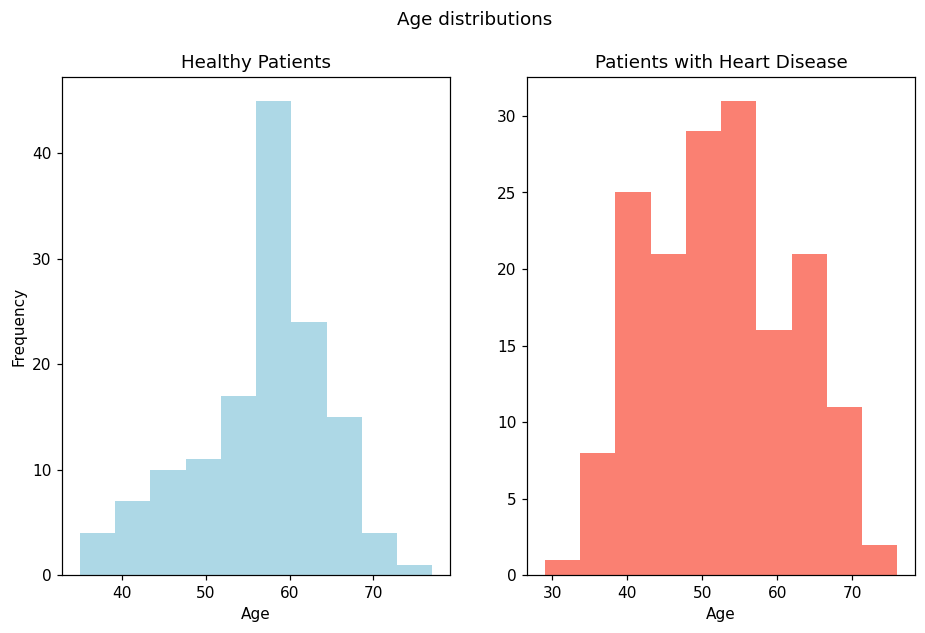

In [9]:
# Lets check the distribution of the age
fig, axis = plt.subplots(nrows=1, ncols=2, figsize = (10,6), dpi=110)

fig.suptitle("Age distributions")

axis[0].hist(healthy['age'], color='lightblue')
axis[0].set(title="Healthy Patients", 
            xlabel="Age", 
            ylabel="Frequency")
axis[1].hist(disease['age'], color='salmon')
axis[1].set(title="Patients with Heart Disease",
            xlabel="Age");

Age distribution seems very similar between healthy and unhealthy patients, with the unhealthy patients ages being more spread out, we can compute mean and std. deviation

In [10]:
print(f"Healthy | Mean {healthy['age'].mean():.4f} | Std. Dev: {healthy['age'].std():.4f}")
print(f"Disease | Mean {disease['age'].mean():.4f} | Std. Dev: {disease['age'].std():.4f}")

Healthy | Mean 56.6014 | Std. Dev: 7.9621
Disease | Mean 52.4970 | Std. Dev: 9.5507


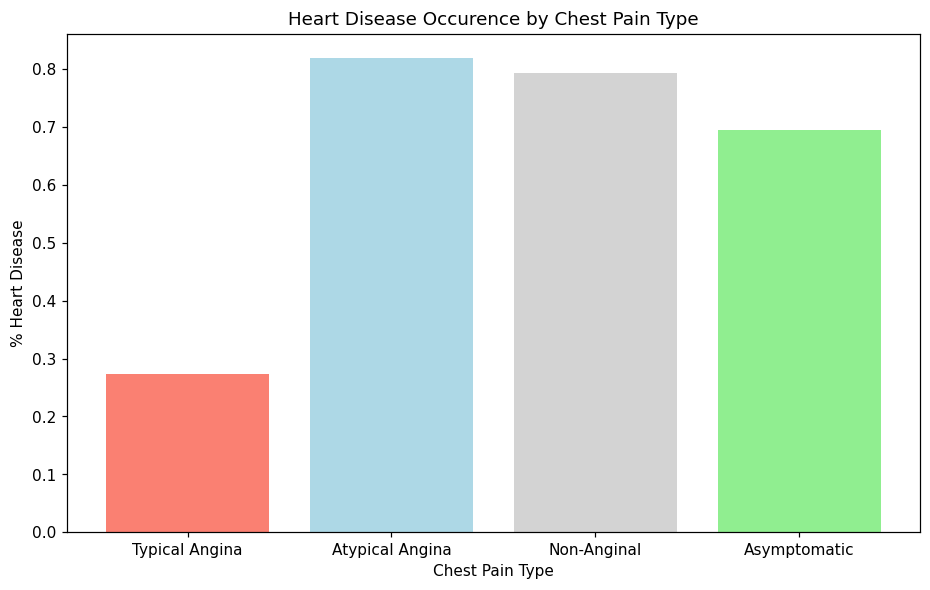

In [11]:
"""
3. cp - chest pain type
   * 0: Typical angina: chest pain related decrease blood supply to the heart
   * 1: Atypical angina: chest pain not related to heart
   * 2: Non-anginal pain: typically esophageal spasms (non heart related)
   * 3: Asymptomatic: chest pain not showing signs of disease
"""

# Sum the target values (since they are 0 or 1 we are counting the 1's) by chest pain type
# Then we divide byt the amount of entris with that Chest Pain type to normalize our data
# since we have different numbers for each CP value
by_cp = data.groupby("cp")
by_cp = by_cp.sum()['target']/by_cp.count()['target']
fig, ax = plt.subplots(figsize=(10,6),
                       dpi=110)

ax.bar(range(4) , by_cp, color=['salmon', 'lightblue', 'lightgray', 'lightgreen'])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["Typical Angina", "Atypical Angina", "Non-Anginal", "Asymptomatic"])
ax.set(title="Heart Disease Occurence by Chest Pain Type",
       xlabel = "Chest Pain Type",
       ylabel = "% Heart Disease");

Here we normalized the frequency to account for sampel size in each category, as it looks like, people with
anything other than the expected chest pain (Typical Angina) are more likely to have Heart Disease, worth of note
that those with `cp=2` (which represents Chest Pain unrelated to the heart) also have a high chance of having heart disease

In [12]:
# Lets take a look at the amount of entries for each CP values just to get some context
# on why we did normalize
pd.crosstab(data['cp'], data['target'])

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


In [13]:
# Lets take a look at a correlation matrix
data.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


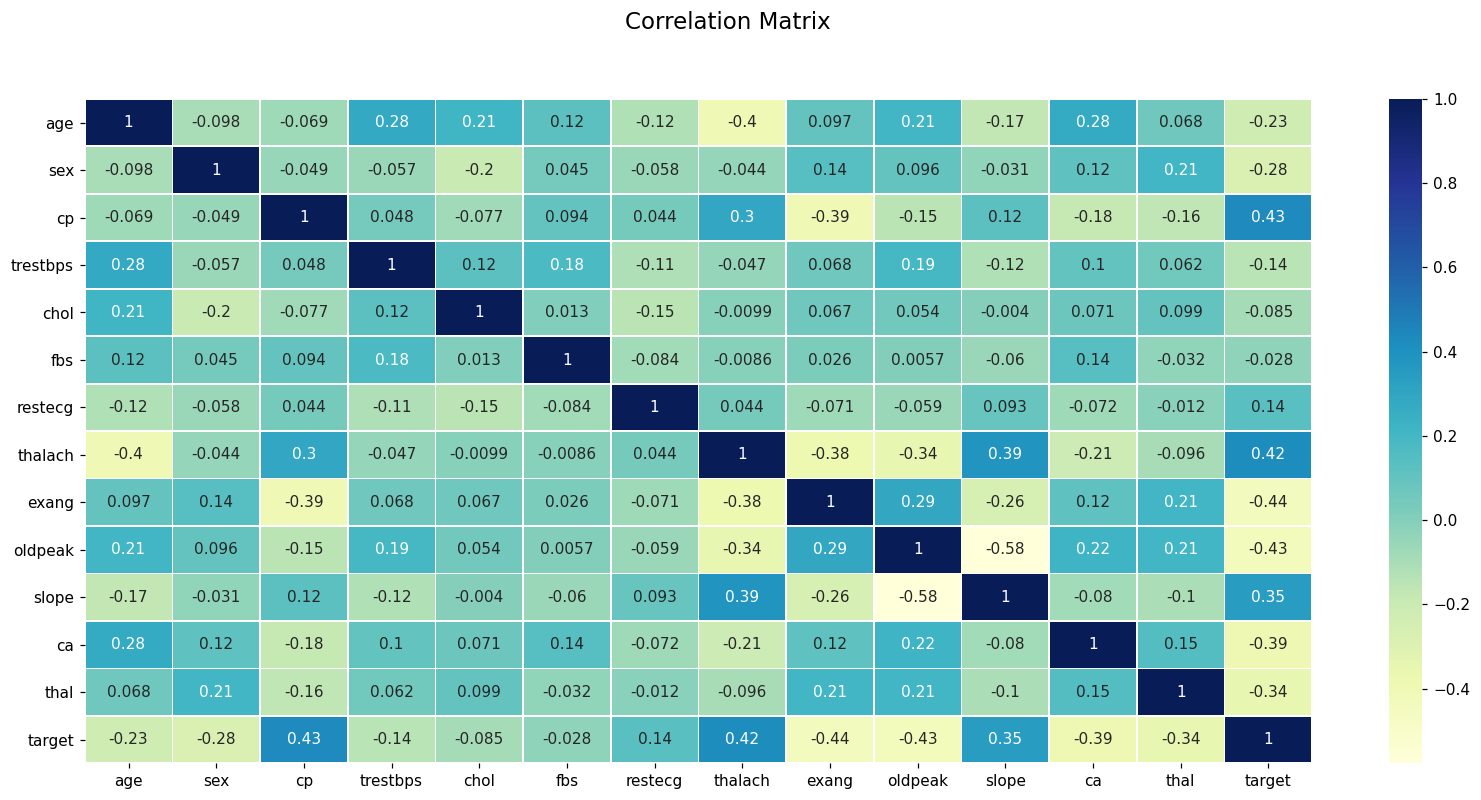

In [14]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(18,8), dpi=110)

ax = sns.heatmap(corr, 
                 annot=True,
                 linewidths=0.5,
                 cmap="YlGnBu")

# The x Parameter goes from 0 to 1 and sets the title's X position (.5 is centered)
fig.suptitle("Correlation Matrix", fontsize=15, x=0.45);

## Modeling

In [15]:
# We wante reproducible results
np.random.seed(42)

# First, we split our data
x = data.drop('target', axis=1)
y = data['target']

# Lets also take the chance to split our data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [16]:
# Creating a function to score multiple models at once
"""
Fit and score a number of models on the same training and test data according to some metrics
models : a dict {"model name": estimator} of models to be avaluated
x_train, y_train : fatures and labels for the training dataset
x_test, y_test : features and labels for the test set
metrics : a dict {"metric": scorer} of metrics to be computed, use make_scorer to create scorer function
"""
def fit_and_score(models, x_train, x_test, y_train, y_test, metrics):
    # Reproducible Results
    np.random.seed(42)
    scores = {}
    for model_name, model in models.items():
        model.fit(x_train, y_train)
    return score(models, x_test, y_test, metrics)

def score(models, x_test, y_test, metrics):
    scores = {}
    if type(models) == dict:
        for model_name, model in models.items():
            scores[model_name] = score(model, x_test, y_test, metrics)
    else:
        scores = { metric: scorer(models, x_test, y_test) for metric, scorer in metrics.items() }
    return scores

In [17]:
# We wiil be trying these models
models = {
    "log_reg" : LogisticRegression(max_iter=1000),
    "knn" : KNeighborsClassifier(),
    "rfc": RandomForestClassifier()
}

# And evaluating then on these metrics
metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [18]:
scores = fit_and_score(models, x_train, x_test, y_train, y_test, metrics)
pd.DataFrame(scores)

,log_reg,knn,rfc
accuracy,0.868852,0.688525,0.836066
precision,0.875000,0.685714,0.843750
recall,0.875000,0.750000,0.843750
f1,0.875000,0.716418,0.843750


Logistic Regression and RandomForests look really promissing, doing well in every metric, KNN on the other hand, may not be a good model for this problem thus we will leave it behind when moving into hyperparameter tuning

In [19]:
# We will now use RandomSearchCV to try and optmize each of our models
# Lets start with Logistic Regression
lr_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}

# Reproducible Results
np.random.seed(42)

# 5-fold cross-validation
lr_random_cv = RandomizedSearchCV(LogisticRegression(max_iter=10000), 
                               lr_grid, 
                               cv=5)

lr_random_cv.fit(x_train, y_train);

In [20]:
# Now we can CV the Random Forest
rf_grid = {
    'n_estimators': np.arange(10, 1000, 50),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_depth': [None, 3,5,10]
}

# Reproducible Results
np.random.seed(42)

# 5-fold cross-validation
rf_random_cv = RandomizedSearchCV(RandomForestClassifier(), 
                               rf_grid, 
                               cv=5)

rf_random_cv.fit(x_train, y_train);

In [21]:
scores = score( {
    'log_reg': lr_random_cv.best_estimator_,
    'rfc': rf_random_cv.best_estimator_
}, x_test, y_test, metrics )

pd.DataFrame(scores)

,log_reg,rfc
accuracy,0.885246,0.868852
precision,0.878788,0.852941
recall,0.906250,0.906250
f1,0.892308,0.878788


In [22]:
# Our models seem tied for the best, on a hunch lets go with Linear Regression 
# for the next step, which is using GridSearch CV

# We will now use RandomSearchCV to try and optmize each of our models
# Lets start with Logistic Regression
lr_grid = {
    'C': np.logspace(-4, 4, 100),
    'solver': ['liblinear']
}

# Reproducible Results
np.random.seed(42)

# 5-fold cross-validation
lr_grid_cv = GridSearchCV(LogisticRegression(max_iter=10000), 
                               lr_grid, 
                               cv=5)

lr_grid_cv.fit(x_train, y_train);

In [40]:
scores = score( {
    'log_reg': lr_grid_cv.best_estimator_
}, x_test, y_test, metrics )

pd.DataFrame(scores)

,log_reg
accuracy,0.885246
f1,0.892308
precision,0.878788
recall,0.906250


In [24]:
# Ok, lets take a look at the best parameters then
lr_grid_cv.best_params_

{'C': 0.20565123083486536, 'solver': 'liblinear'}

## Evaluating our model beyond accuracy

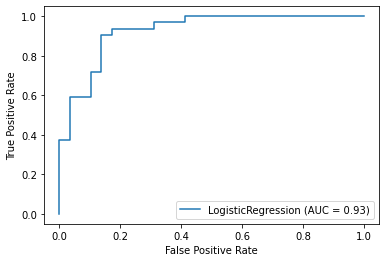

In [25]:
# plot_roc_curve gives us an easy way to see the ROC curve
best_lr = lr_grid_cv.best_estimator_
plot_roc_curve(best_lr, x_test, y_test);

In [29]:
# We can also use classification_report
y_preds = best_lr.predict(x_test)
print(classification_report(y_test, y_preds, target_names=["Healthy", "Heart Disease"]))

               precision    recall  f1-score   support

      Healthy       0.89      0.86      0.88        29
Heart Disease       0.88      0.91      0.89        32

     accuracy                           0.89        61
    macro avg       0.89      0.88      0.88        61
 weighted avg       0.89      0.89      0.89        61



In [42]:
"""
Run CV Scoring from sklearn on a set of model for some given metrics
"""
def cv_score(models, x, y, metrics):
    # Reproducible results
    np.random.seed(42)
    scores = {}
    if type(models) == dict:
        for model_name, model in models.items():
            scores[model_name] = cv_score(model, x, y, metrics)
        return scores
    
    return { 
        metric : cross_val_score(best_lr, x_train, y_train, scoring=scorer) for metric, scorer in metrics.items() 
    }

cv_score(best_lr, x, y, metrics)

{'accuracy': array([0.81632653, 0.85714286, 0.8125    , 0.85416667, 0.8125    ]),
 'precision': array([0.82142857, 0.83333333, 0.78125   , 0.82758621, 0.81481481]),
 'recall': array([0.85185185, 0.92592593, 0.92592593, 0.92307692, 0.84615385]),
 'f1': array([0.83636364, 0.87719298, 0.84745763, 0.87272727, 0.83018868])}

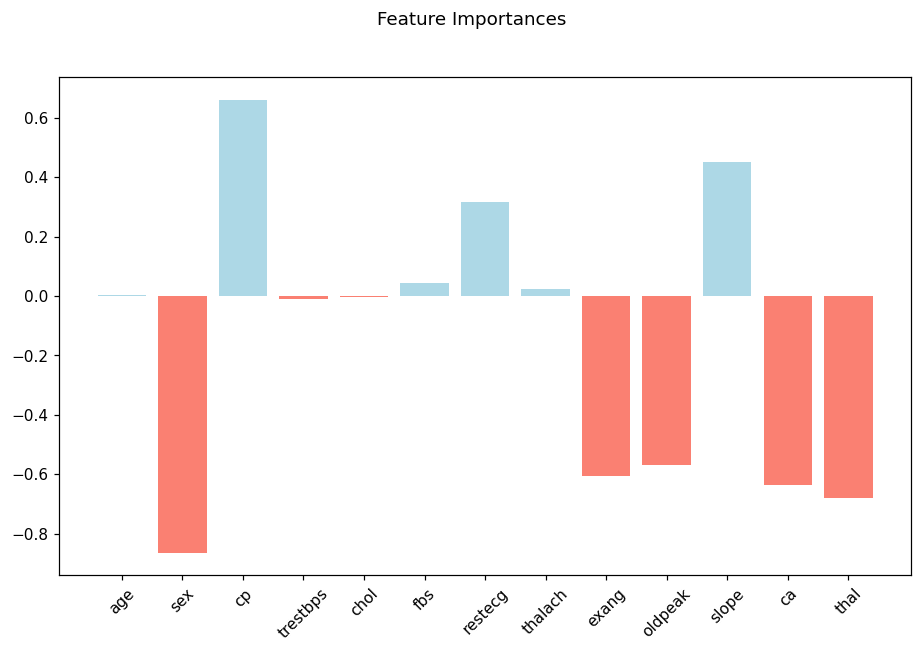

In [55]:
# At Last, lets see our feature importance


fig, ax = plt.subplots(figsize=(10,6), dpi=110)

fig.suptitle("Feature Importances")

ax.bar(range(13), best_lr.coef_[0], 
       color = ["salmon" if x < 0 else "lightblue" for x in best_lr.coef_[0]])
ax.set_xticks(range(13))
ax.set_xticklabels(x.columns, rotation=45);